In [93]:
import numpy as np
from numpy import genfromtxt

import functools
import scipy
from scipy.stats import rayleigh
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib widget

In [94]:
data = genfromtxt('./data_rare.txt', delimiter=' ', dtype=float, skip_header = 3)
print(data.shape)

# Fixing bin edges
HIST_BINS = np.linspace(0, 1000, 100) # !!!
centers = (0.5 * (HIST_BINS[1:] + HIST_BINS[:-1]))

# Range for plotting fits (more points = more resolution)
dv = 0.1
v_plot_range = np.arange(0, 1000, dv) # !!!

#do all fitting
best_fit_times = []
legend_times = []
y_times = []
r_times = []

#generate all data
for t in range(data.shape[0]):
    y, _ = np.histogram(data[t], HIST_BINS, density = 1)
    #sigma = sqrt(kT / m)
    pars, cov = curve_fit(lambda x, sigma : rayleigh.pdf(x, 0, sigma), centers, y, p0=[100]) # initial guess for sigma
    r = np.sum((y - rayleigh.pdf(centers, 0, pars[0])) ** 2) / np.sum((y - np.mean(y)) ** 2)
    
    y_times += [y]
    best_fit_times += [rayleigh.pdf(v_plot_range, 0, pars[0])]
    legend_times += [(pars[0] ** 2,2 * pars[0] * cov[0,0], r)]
    r_times += [r]

(1666, 200)


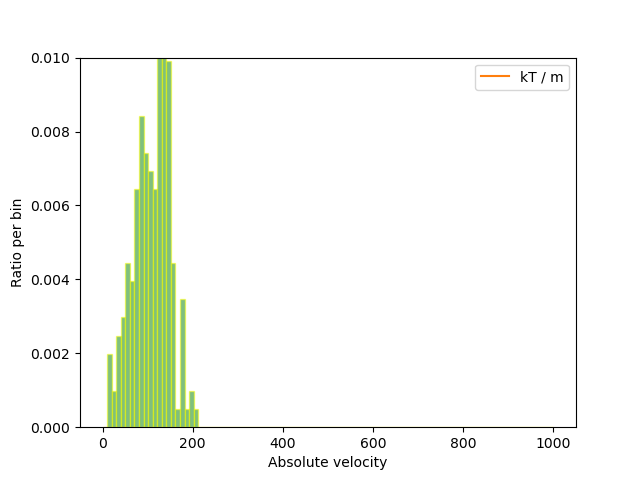

In [95]:
def animate(t, bar_container, plot, legend):
    # update histogram
    for count, rect in zip(y_times[t], bar_container.patches):
        rect.set_height(count)
    
    # update plot
    plot[0].set_data(v_plot_range, best_fit_times[t])
    
    # update legend
    lab = '$ kT / m = {:.1f} \pm {:.1f} $, \n $1-R^2={:.5f}$'.format(*(legend_times[t]))
    legend.get_texts()[0].set_text(lab)
    return bar_container, plot, legend

fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data[0], HIST_BINS, lw=1, ec="yellow", fc="green", alpha=0.5, density = True)

plot = ax.plot([], [], label='kT / m')
legend = ax.legend(loc=1)

ax.set_ylim(top=0.01)  # set safe limit to ensure that all data is visible.
ax.set_ylabel('Ratio per bin')
ax.set_xlabel('Absolute velocity')

frames = data.shape[0]
anim = functools.partial(animate, bar_container=bar_container, plot=plot, legend=legend)
ani = animation.FuncAnimation(fig, anim, frames, repeat=False, blit=True)

plt.show()

In [100]:
ani.event_source.stop()
plt.close()

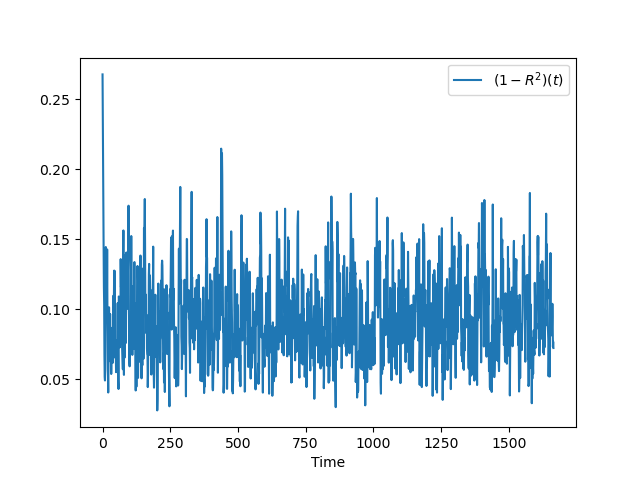

In [98]:
_, ax2 = plt.subplots()
ax2.plot(np.arange(data.shape[0]), np.array(r_times), label='$(1-R^2)(t)$')
ax2.legend(loc=1)
ax2.set_xlabel('Time')
plt.show()

In [ ]:
# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15, metadata=dict(artist='Kirill Grinko'), bitrate=180)
ani.save('scatter.gif', writer=writer)